# Digital Linear Filters

Graphical explanation between standard DLF, lagged convolution DLF, and splined DLF.

The examples assumes the Hankel transform, hence wavenumber-domain ($k$) to frequency-domain ($f$). But the same applies for the Fourier transform from frequency-domain ($f$) to time-domain ($t$), or for any arbitrary two domains.

Filter weights and the actual DLF are ignored here, we only look at the required data points in the $k$-domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

In [3]:
# Points in f-domain
f = np.array([0.2, 0.7, 5, 25, 100])

# Filter base
base = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2])

## Standard digital filter

For each point in the frequency-domain you have to calculate $n$ points in the wavenumber-domain, where $n$ is the filter length.

### Implementation in `empymod`

This is the most precise one, as no interpolation is used, but generally the slowest one. It is the default method for the Hankel transform.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = None                     # Default
    htarg = {'pts_per_dec': None}  # Default
    
The standard DLF works also with the parallel option, `opt = 'parallel'`.

For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': 0}     # Only implemented from empymod v1.5.2 onwards


Points in f-domain   :: 5
Filter length        :: 5
Req. pts in k-domain :: 25


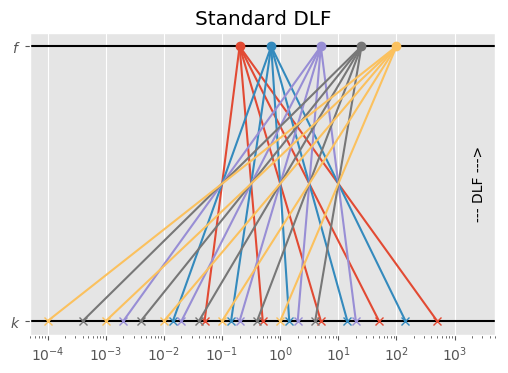

In [4]:
# Required points in the k-domain
k = base/f[:,None]

# Print information
print('Points in f-domain   ::', f.size)
print('Filter length        ::', base.size)
print('Req. pts in k-domain ::', k.size)

# Figure
plt.figure()
plt.title('Standard DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)

for i, val in enumerate(f):
    for ii, ival in enumerate(k[i, :]):
        plt.plot(ival, 0, 'C'+str(i)+'x')
        plt.plot([ival, val], [0, 1], 'C'+str(i))
    plt.plot(val, 1, 'C'+str(i)+'o')
    
plt.text(2e3, 0.5, '--- DLF --->', rotation=90, va='center')

plt.xscale('log')
plt.yticks([0, 1], (r'$k$', r'$f$'))
plt.xlim([5e-5, 5e3])
plt.show()

## Lagged convolution DLF

The spacing of the filter base is used to get from minimum to maximum required wavenumber; for each complete set the DLF is executed to calculate the frequency-domain response, and interpolation is carried out in the frequency-domain.
  
### Implementation in `empymod`

This is usually the fastest option, and generally still more than sufficiently precise. It is the default method for the Fourier transform.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = 'spline'
    htarg = {'pts_per_dec': None}  # Default

For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': None}  # Default


Points in f-domain   :: 5
Filter length        :: 5
Req. pts in k-domain :: 8


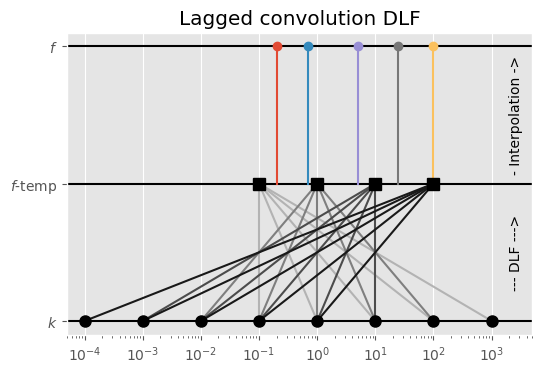

In [5]:
# Required points in the k-domain
k2 = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

# Intermediat values in the f-domain
f2 = np.array([1e-1, 1e0, 1e1, 1e2])

# Print information
print('Points in f-domain   ::', f.size)
print('Filter length        ::', base.size)
print('Req. pts in k-domain ::', k2.size)

# Figure
plt.figure()
plt.title('Lagged convolution DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)
plt.hlines(0.5, 1e-5, 1e5)

for i, val in enumerate(f2):
    for ii in range(base.size):
        plt.plot([k2[-1-ii-i], val], [0, 0.5], str(0.7-0.2*i))

for iii, val2 in enumerate(f):
    plt.plot(val2, 1, 'C'+str(iii)+'o')
    plt.plot([val2, val2], [0.5, 1], 'C'+str(iii))

plt.text(2e3, 0.75, '- Interpolation ->', rotation=90, va='center')
plt.text(2e3, 0.25, '--- DLF --->', rotation=90, va='center')

plt.plot(k2, k2*0, 'ko', ms=8)
plt.plot(f2, f2*0+0.5, 'ks', ms=8)
plt.xscale('log')
plt.yticks([0, 0.5, 1], (r'$k$', r'$f$-temp', r'$f$'))
plt.xlim([5e-5, 5e3])
plt.show()

## Splined DLF

In the splined DLF $m$ points per decade are used from minimum to maximum required wavenumber; then the required wavenumbers are interpolated in the wavenumber-domain, and the DLF is exececuted subsequently.

### Implementation in `empymod`

This option can, at times, yield more precise results than the lagged convolution DLF, while being slower than the lagged convolution DLF but faster than the standard DLF. However, you have to carefully choose (or better, test) the parameter `pts_per_dec`.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = 'spline'
    htarg = {'pts_per_dec': your_desired_value}
    
For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': your_desired_value}


Points in f-domain   :: 5
Filter length        :: 5
Points per decade    :: 3
Req. pts in k-domain :: 22


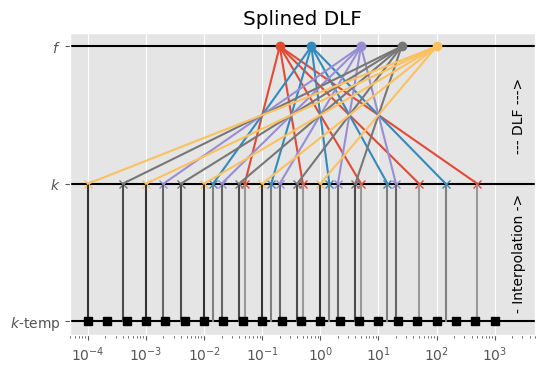

In [6]:
# Required points in the k-domain
kmin = np.log10(k).min()
kmax = np.ceil(np.log10(k).max())
pts_per_dec = 3
k2 = np.logspace(kmin, kmax, int((kmax-kmin)*pts_per_dec+1))

# Print information
print('Points in f-domain   ::', f.size)
print('Filter length        ::', base.size)
print('Points per decade    ::', pts_per_dec)
print('Req. pts in k-domain ::', k2.size)

# Figure
plt.figure()
plt.title('Splined DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0.5, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)

for i, val in enumerate(f):
    for ii, ival in enumerate(k[i, :]):
        plt.plot(ival, 0.5, 'C'+str(i)+'x')
        plt.plot([ival, ival], [0, 0.5], str(0.6-0.1*i))
        plt.plot([ival, val], [0.5, 1], 'C'+str(i))
    plt.plot(val, 1, 'C'+str(i)+'o')
    
plt.text(2e3, 0.25, '- Interpolation ->', rotation=90, va='center')
plt.text(2e3, 0.75, '--- DLF --->', rotation=90, va='center')

plt.plot(k2, k2*0, 'ks')
plt.xscale('log')
plt.yticks([0, 0.5, 1], (r'$k$-temp', r'$k$', r'$f$'))
plt.xlim([5e-5, 5e3])
plt.show()

In [7]:
from empyscripts import versions
versions('HTML')